In [ ]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")
from torchinfo import summary

import torch
import torchvision
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import numpy as np
import random

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import glob
from tqdm import tqdm

In [ ]:
train_transforms = A.Compose([
    A.SmallestMaxSize(max_size=350),
    A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.02, rotate_limit=15, p=0.3), 
    A.RandomCrop(height=256, width=256),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),   
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

test_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.CenterCrop(height=256, width=256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.01, rotate_limit=5, p=0.2),
        ToTensorV2()
    ]
)

In [ ]:
# use to download the dataset ------------------------------------------------------------------------- 

# import kagglehub 

# # Download latest version
# path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

# print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


In [ ]:
import glob
import os
import random
from itertools import chain as flatten

train_data_path = 'dataset/brain_tumor_mri_dataset/versions/1/Training' 
test_data_path = 'dataset/brain_tumor_mri_dataset/versions/1/Testing'

train_image_paths = []
classes = []

for class_path in glob.glob(os.path.join(train_data_path, '*')):
    class_path = os.path.normpath(class_path)
    class_name = os.path.basename(class_path)  # just the class name, e.g. 'glioma'

    for img_path in glob.glob(os.path.join(class_path, '*')):
        img_path = img_path.replace('\\', '/')  # convert to forward slashes
        train_image_paths.append(img_path)
        classes.append(class_name)

random.shuffle(train_image_paths)

print('train_image_path example: ', train_image_paths[0])

first_img_class = train_image_paths[10].split('/')[-2]
print('class example: ', first_img_class)

train_image_paths, valid_image_paths = (
    train_image_paths[:int(0.8 * len(train_image_paths))],
    train_image_paths[int(0.8 * len(train_image_paths)):]
)

test_image_paths = []
for class_path in glob.glob(os.path.join(test_data_path, '*')):
    for img_path in glob.glob(os.path.join(class_path, '*')):
        test_image_paths.append(img_path.replace('\\', '/'))

# Output sizes
print("Train size: {}\nValid size: {}\nTest size: {}".format(
    len(train_image_paths), len(valid_image_paths), len(test_image_paths)
))


train_image_path example:  /kaggle/input/brain-tumor-mri-dataset/Training/meningioma/Tr-me_0337.jpg
class example:  meningioma
Train size: 4569
Valid size: 1143
Test size: 1311


In [ ]:
unique_classes = [os.path.basename(path) for path in glob.glob(os.path.join(train_data_path, '*'))]
idx_to_class = {i:j for i, j in enumerate(unique_classes)}
print(idx_to_class)
class_to_idx = {class_name: idx for idx, class_name in enumerate(unique_classes)}
print(class_to_idx)

{0: 'pituitary', 1: 'notumor', 2: 'meningioma', 3: 'glioma'}
{'pituitary': 0, 'notumor': 1, 'meningioma': 2, 'glioma': 3}


In [ ]:
class MRIDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image=image)["image"]

        return image, label


train_dataset = MRIDataset(train_image_paths,train_transforms)
valid_dataset = MRIDataset(valid_image_paths,test_transforms) #test transforms are applied
test_dataset = MRIDataset(test_image_paths,test_transforms)

print(len(train_dataset), len(valid_dataset), len(test_dataset) )

4569 1143 1311


In [ ]:
print(train_dataset[123][0].size())

torch.Size([3, 256, 256])


In [ ]:
train_dataset[30][0]

tensor([[[-2.0665, -2.0665, -2.0665,  ..., -2.0665, -2.0837, -2.0837],
         [-2.0665, -2.0665, -2.0665,  ..., -2.0665, -2.0665, -2.0665],
         [-2.0665, -2.0665, -2.0665,  ..., -2.0665, -2.0494, -2.0494],
         ...,
         [-2.0323, -2.0323, -2.0323,  ..., -2.0494, -2.0494, -2.0494],
         [-2.0494, -2.0494, -2.0323,  ..., -2.0494, -2.0494, -2.0494],
         [-2.0665, -2.0494, -2.0323,  ..., -2.0494, -2.0494, -2.0494]],

        [[-1.9832, -1.9832, -1.9832,  ..., -1.9832, -2.0007, -2.0007],
         [-1.9832, -1.9832, -1.9832,  ..., -1.9832, -1.9832, -1.9832],
         [-1.9832, -1.9832, -1.9832,  ..., -1.9832, -1.9657, -1.9657],
         ...,
         [-1.9482, -1.9482, -1.9482,  ..., -1.9657, -1.9657, -1.9657],
         [-1.9657, -1.9657, -1.9482,  ..., -1.9657, -1.9657, -1.9657],
         [-1.9832, -1.9657, -1.9482,  ..., -1.9657, -1.9657, -1.9657]],

        [[-1.7522, -1.7522, -1.7522,  ..., -1.7522, -1.7696, -1.7696],
         [-1.7522, -1.7522, -1.7522,  ..., -1

In [ ]:
print('The shape of tensor for 50th image in train dataset: ',train_dataset[10][0].shape)
print('The label for 50th image in train dataset: ',train_dataset[1][1])

The shape of tensor for 50th image in train dataset:  torch.Size([3, 256, 256])
The label for 50th image in train dataset:  2


1866
1866


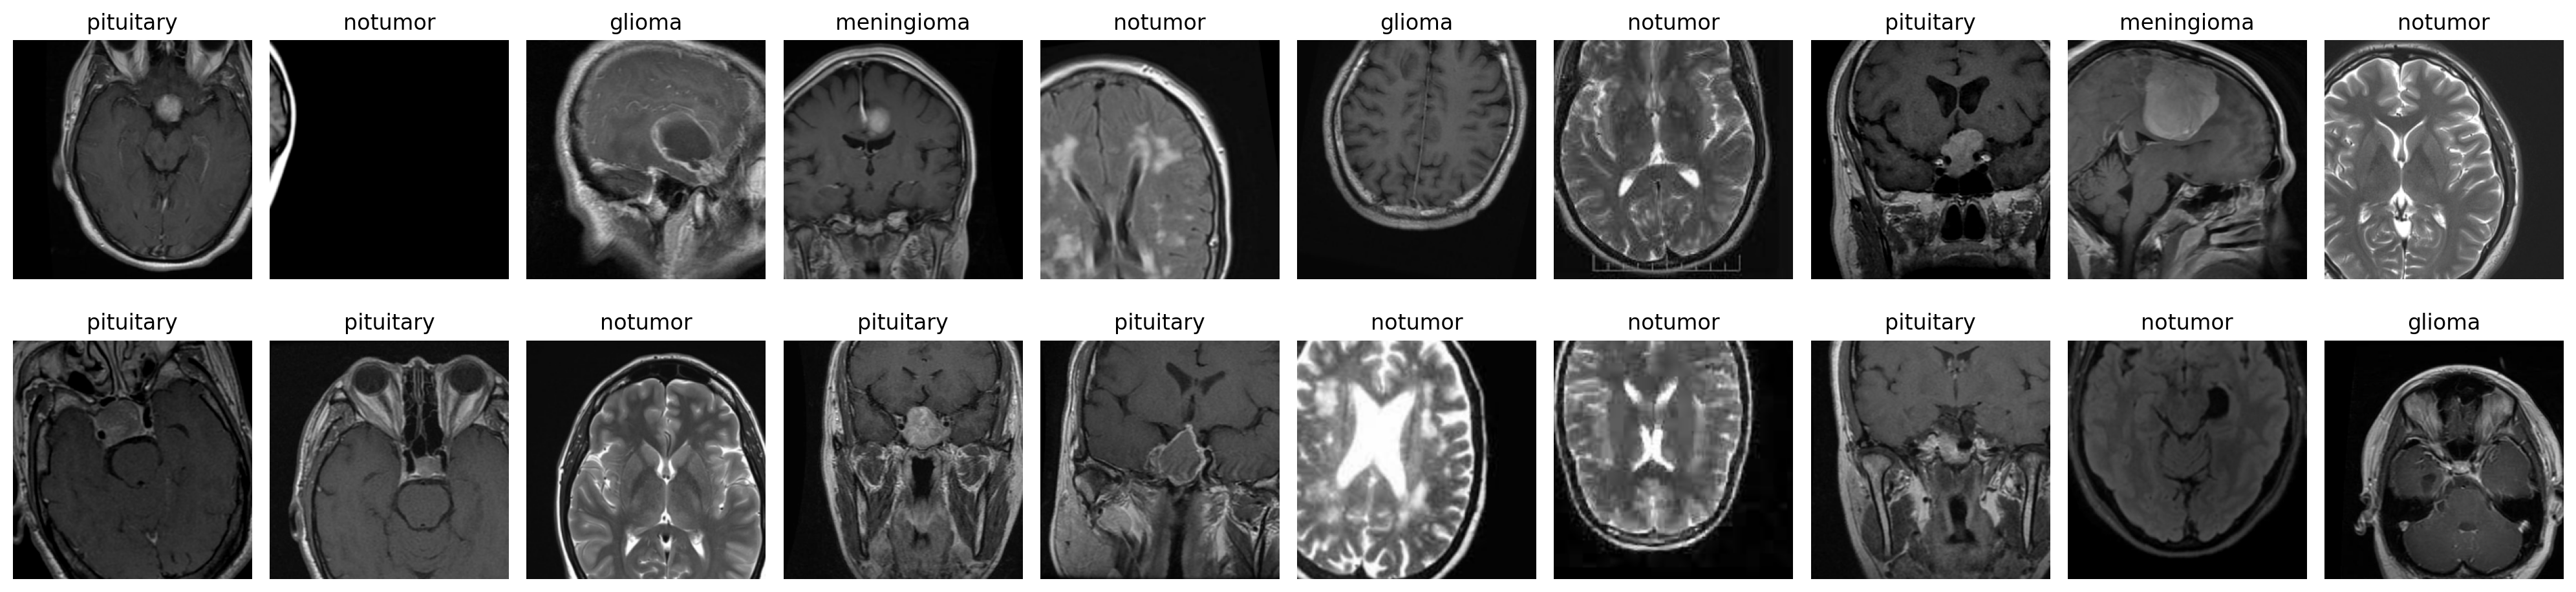

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def visualize_augmentations(dataset, idx, samples=20, cols=10, random_img = False):
    print(idx)
    dataset = copy.deepcopy(dataset)
   
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols


    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 5))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1,len(train_image_paths))
        image, lab = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx_to_class[lab])
    plt.tight_layout(pad=1)
    plt.show()

rand = np.random.randint(1,len(train_image_paths))
print(rand)
visualize_augmentations(train_dataset,rand, random_img = True)

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True
)

valid_loader = DataLoader(
    valid_dataset, batch_size=32, shuffle=True
)

test_loader = DataLoader(
    test_dataset, batch_size=32, shuffle=False
)

23


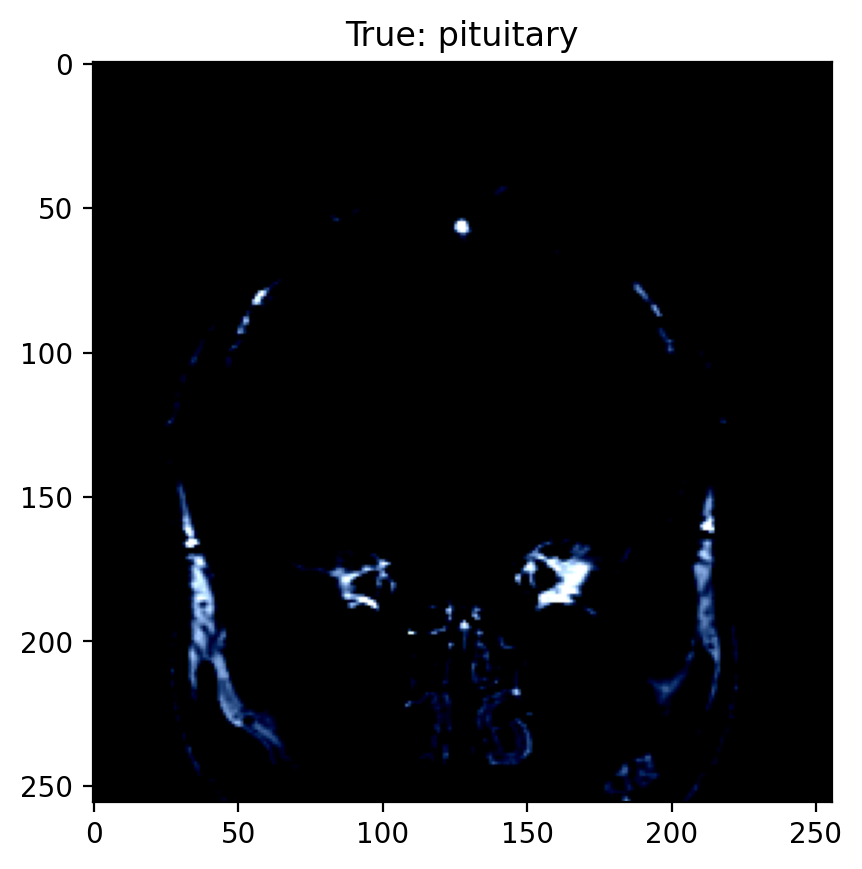

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

# Define your class names --> change accordingly
CLASS_NAMES = ['glioma', 'meningioma', 'notumor', 'pituitary']


# Get a batch from dataloader
train_features, train_labels = next(iter(valid_loader))

# Pick a random image from the batch
random_idx = random.randint(0, len(train_features)-1)
print(random_idx)
img = train_features[random_idx]
true_label = train_labels[random_idx].item()

img_display = img.squeeze()
if img_display.shape[0] == 3:  # If channels first (3, H, W)
    img_display = img_display.permute(1, 2, 0)  # Convert to (H, W, 3)
    plt.imshow(img_display)
else:
    plt.imshow(img_display, cmap="gray")

plt.title(f"True: {CLASS_NAMES[true_label]}")
plt.show()



In [ ]:
print(next(iter(train_loader))[0].shape)
next(iter(train_loader))[1].shape

torch.Size([32, 3, 256, 256])


torch.Size([32])

notumor  notumor


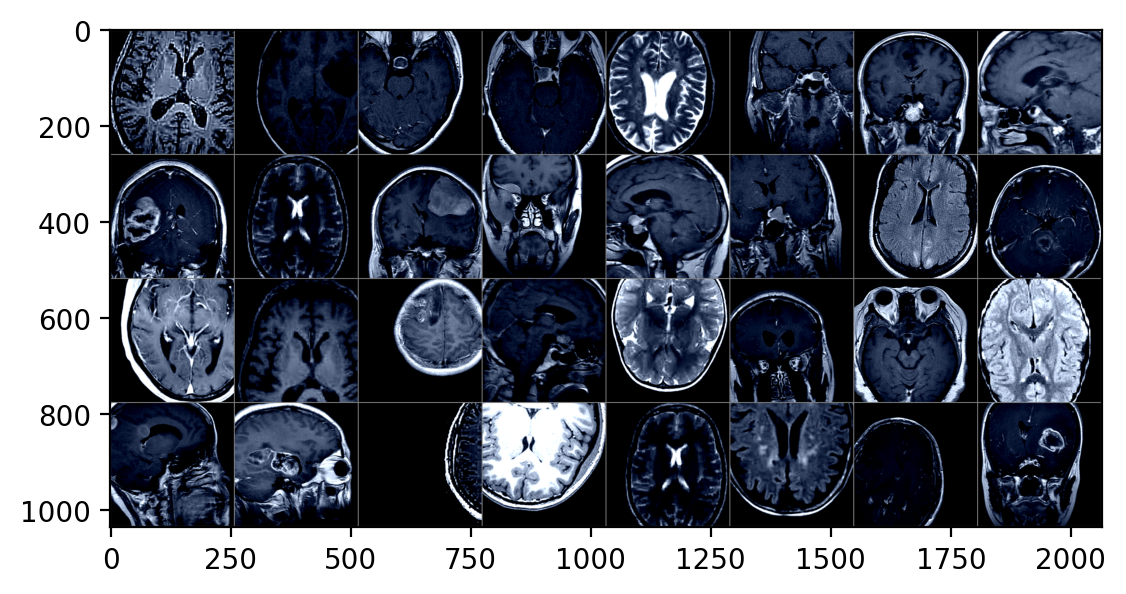

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="hot")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(train_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=False)
print('  '.join(unique_classesq[labels[j]] for j in range(2)))

In [ ]:
# define the model structure

class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size,
                                   stride=stride, padding=padding, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class Block(nn.Module):
    def __init__(self, in_filters, out_filters, reps, strides=1, start_with_relu=True, grow_first=True):
        super(Block, self).__init__()

        if out_filters != in_filters or strides != 1:
            self.skip = nn.Conv2d(in_filters, out_filters, 1, stride=strides, bias=False)
            self.skipbn = nn.BatchNorm2d(out_filters)
        else:
            self.skip = None

        self.relu = nn.ReLU(inplace=True)
        rep = []

        filters = in_filters
        if grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters, out_filters, 3, stride=1, padding=1, bias=False))
            rep.append(nn.BatchNorm2d(out_filters))
            filters = out_filters

        for i in range(reps - 1):
            rep.append(self.relu)
            rep.append(SeparableConv2d(filters, filters, 3, stride=1, padding=1, bias=False))
            rep.append(nn.BatchNorm2d(filters))

        if not grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters, out_filters, 3, stride=1, padding=1, bias=False))
            rep.append(nn.BatchNorm2d(out_filters))

        if not start_with_relu:
            rep = rep[1:]
        else:
            rep[0] = nn.ReLU(inplace=False)

        if strides != 1:
            rep.append(nn.MaxPool2d(3, strides, 1))
        self.rep = nn.Sequential(*rep)

    def forward(self, inp):
        x = self.rep(inp)

        if self.skip is not None:
            skip = self.skip(inp)
            skip = self.skipbn(skip)
        else:
            skip = inp

        x += skip
        return x

class Xception(nn.Module):
    def __init__(self, num_classes=4, require_flatten=True, pooling=None):

        super(Xception, self).__init__()
        self.num_classes = num_classes
        self.require_flatten = require_flatten
        self.pooling = pooling

        # Entry flow
        self.conv1 = nn.Conv2d(3, 32, 3, 2, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU(inplace=True)

        # Entry flow blocks
        self.block1 = Block(64, 128, 2, 2, start_with_relu=False, grow_first=True)
        self.block2 = Block(128, 256, 2, 2, start_with_relu=True, grow_first=True)
        self.block3 = Block(256, 728, 2, 2, start_with_relu=True, grow_first=True)

        # Middle flow (8 blocks)
        self.block4 = Block(728, 728, 3, 1, start_with_relu=True, grow_first=True)
        self.block5 = Block(728, 728, 3, 1, start_with_relu=True, grow_first=True)
        self.block6 = Block(728, 728, 3, 1, start_with_relu=True, grow_first=True)
        self.block7 = Block(728, 728, 3, 1, start_with_relu=True, grow_first=True)
        self.block8 = Block(728, 728, 3, 1, start_with_relu=True, grow_first=True)
        self.block9 = Block(728, 728, 3, 1, start_with_relu=True, grow_first=True)
        self.block10 = Block(728, 728, 3, 1, start_with_relu=True, grow_first=True)
        self.block11 = Block(728, 728, 3, 1, start_with_relu=True, grow_first=True)

        # Final flow
        self.block12 = Block(728, 1024, 2, 2, start_with_relu=True, grow_first=False)

        self.conv3 = SeparableConv2d(1024, 1536, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(1536)
        self.relu3 = nn.ReLU(inplace=True)

        self.conv4 = SeparableConv2d(1536, 2048, 3, 1, 1)
        self.bn4 = nn.BatchNorm2d(2048)
        self.relu4 = nn.ReLU(inplace=True)

        # Classification head
        if require_flatten:
            self.fc = nn.Linear(2048, num_classes) 

    def features(self, input):
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        x = self.block11(x)
        x = self.block12(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)

        return x

    def forward(self, input):
        x = self.features(input)

        if self.require_flatten:
            x = F.adaptive_avg_pool2d(x, (1, 1))
            x = x.view(x.size(0), -1)
            x = self.fc(x)
        else:
            if self.pooling == 'avg':
                x = F.adaptive_avg_pool2d(x, (1, 1))
                x = x.view(x.size(0), -1)
            elif self.pooling == 'max':
                x = F.adaptive_max_pool2d(x, (1, 1))
                x = x.view(x.size(0), -1)

        return x

In [ ]:
model = Xception(num_classes=4, require_flatten=True)
summary(model, input_size=(1, 3, 299, 299))  # (batch_size, channels, height, width)

Layer (type:depth-idx)                   Output Shape              Param #
Xception                                 [1, 4]                    --
├─Conv2d: 1-1                            [1, 32, 149, 149]         864
├─BatchNorm2d: 1-2                       [1, 32, 149, 149]         64
├─ReLU: 1-3                              [1, 32, 149, 149]         --
├─Conv2d: 1-4                            [1, 64, 149, 149]         18,432
├─BatchNorm2d: 1-5                       [1, 64, 149, 149]         128
├─ReLU: 1-6                              [1, 64, 149, 149]         --
├─Block: 1-7                             [1, 128, 75, 75]          --
│    └─Sequential: 2-1                   [1, 128, 75, 75]          --
│    │    └─SeparableConv2d: 3-1         [1, 128, 149, 149]        8,768
│    │    └─BatchNorm2d: 3-2             [1, 128, 149, 149]        256
│    │    └─ReLU: 3-3                    [1, 128, 149, 149]        --
│    │    └─SeparableConv2d: 3-4         [1, 128, 149, 149]        17,536
│

In [ ]:
model = Xception(num_classes=4, require_flatten=True)
dummy_input = torch.randn(1, 3, 299, 299)

# Export to ONNX
torch.onnx.export(model, dummy_input, "xception_model.onnx",
                  export_params=True, opset_version=11,
                  input_names=['input'], output_names=['output'])

# open xception_model.onnx in Netron (https://netron.app/) to see the structure

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BrainTumorClassifier(nn.Module):
    def __init__(self, num_classes=4, pretrained_weights=None):
        super(BrainTumorClassifier, self).__init__()

        # Use Xception as feature extractor (without classification head). 
        self.backbone = Xception(num_classes=4, require_flatten=False, pooling='avg')

        if pretrained_weights:
            self.backbone.load_state_dict(pretrained_weights)

        self.freeze_backbone()

        # Custom classifier head
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(2048, 128), 
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(128, num_classes)
        )

    def freeze_backbone(self):
        """Freeze backbone for transfer learning"""
        for param in self.backbone.parameters():
            param.requires_grad = False

    def unfreeze_backbone(self, unfreeze_last_n_blocks=3):
        """Unfreeze last n blocks for fine-tuning"""
        # Unfreeze all parameters first
        for param in self.backbone.parameters():
            param.requires_grad = True


    def forward(self, x):
        features = self.backbone(x)  
        output = self.classifier(features)
        return output

model = BrainTumorClassifier(num_classes=4)
model

BrainTumorClassifier(
  (backbone): Xception(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (block1): Block(
      (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (rep): Sequential(
        (0): SeparableConv2d(
          (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
          (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics import Accuracy, Precision, Recall
import time
from collections import defaultdict

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.best_weights = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
            if self.verbose:
                print(f"Validation loss improved to {val_loss:.6f}")
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")

        if self.counter >= self.patience:
            if self.restore_best_weights and self.best_weights is not None:
                model.load_state_dict(self.best_weights)
                if self.verbose:
                    print("Restored best weights")
            return True
        return False

    def save_checkpoint(self, model):
        self.best_weights = {key: value.cuda().clone()
                           for key, value in model.state_dict().items()}

def train_epoch(model, train_loader, optimizer, criterion, device, metrics):
    model.train()
    running_loss = 0.0

    # Reset metrics
    for metric in metrics.values():
        metric.reset()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Update metrics
        preds = torch.argmax(outputs, dim=1)
        for metric in metrics.values():
            metric.update(preds.to(device), target.to(device))

        # Print progress
        if batch_idx % 50 == 0:
            print(f'Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.6f}')

    epoch_metrics = {name: metric.compute().item() for name, metric in metrics.items()}
    epoch_loss = running_loss / len(train_loader)

    return epoch_loss, epoch_metrics

def validate_epoch(model, val_loader, criterion, device, metrics):
    model.eval()
    running_loss = 0.0

   
    for metric in metrics.values():
        metric.reset()  # Reset metrics

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)

            running_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)

            for metric in metrics.values():
                metric.update(preds.to(device), target.to(device))

    # Compute final metrics
    epoch_metrics = {name: metric.compute().item() for name, metric in metrics.items()}
    epoch_loss = running_loss / len(val_loader)

    return epoch_loss, epoch_metrics

In [ ]:
def train_epoch_mixed_precision(model, dataloader, optimizer, criterion, device, metrics, scaler):
    model.train()
    running_loss = 0.0

    # Reset metrics
    for metric in metrics.values():
        metric.reset()

    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            output = model(data)
            loss = criterion(output, target)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        lr_scheduler.step()

        running_loss += loss.item()

        preds = torch.argmax(output, dim=1)
        for metric in metrics.values():
            metric.update(preds, target)

    epoch_metrics = {name: metric.compute().item() for name, metric in metrics.items()}
    return running_loss / len(dataloader), epoch_metrics

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

epochs = 30

optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01) 
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  

lr_scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.01,  # Higher max learning rate
    epochs=epochs,
    steps_per_epoch=len(train_loader),
    pct_start=0.3,  # Warm up for 30% of training
    anneal_strategy='cos'
)

early_stopping = EarlyStopping(patience=10, restore_best_weights=True, min_delta=0.001)

scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

unfreeze_epoch = 10  # Unfreeze after 10 epochs

metrics = {
    'accuracy': Accuracy(task='multiclass', num_classes=4).to(device),
    'precision': Precision(task='multiclass', num_classes=4, average='macro').to(device),
    'recall': Recall(task='multiclass', num_classes=4, average='macro').to(device)
}

history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")

    if epoch == unfreeze_epoch:
        print("Unfreezing backbone for fine-tuning...")
        model.unfreeze_backbone()
                # Reduce learning rate when unfreezing
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1

    # Training with mixed precision
    if scaler:
        train_loss, train_metrics = train_epoch_mixed_precision(
            model, train_loader, optimizer, criterion, device, metrics, scaler
        )
    else:
        train_loss, train_metrics = train_epoch(
            model, train_loader, optimizer, criterion, device, metrics
        )

    # Validation
    val_loss, val_metrics = validate_epoch(model, valid_loader, criterion, device, metrics)

    # Store history
    history['loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['accuracy'].append(train_metrics['accuracy'])
    history['val_accuracy'].append(val_metrics['accuracy'])

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}")
    print(f"Train Acc: {train_metrics['accuracy']:.4f}, Val Acc: {val_metrics['accuracy']:.4f}")
    print(f"Train Prec: {train_metrics['precision']:.4f}, Val Prec: {val_metrics['precision']:.4f}")

    # Early stopping
    if early_stopping(val_loss, model):
        print("Early stopping triggered!")
        break

print("Training completed!")


Epoch 1/30
Train Loss: 1.3660, Val Loss: 1.2912, LR: 0.000690
Train Acc: 0.3362, Val Acc: 0.3990
Train Prec: 0.3481, Val Prec: 0.4281

Epoch 2/30
Train Loss: 1.2911, Val Loss: 1.2456, LR: 0.001525
Train Acc: 0.4010, Val Acc: 0.4488
Train Prec: 0.3998, Val Prec: 0.3083
Validation loss improved to 1.245600

Epoch 3/30
Train Loss: 1.2669, Val Loss: 1.1988, LR: 0.002803
Train Acc: 0.4351, Val Acc: 0.4681
Train Prec: 0.4234, Val Prec: 0.4394
Validation loss improved to 1.198847

Epoch 4/30
Train Loss: 1.2931, Val Loss: 1.2587, LR: 0.004372
Train Acc: 0.4051, Val Acc: 0.4926
Train Prec: 0.4009, Val Prec: 0.3599
EarlyStopping counter: 1 out of 10

Epoch 5/30
Train Loss: 1.2814, Val Loss: 1.1925, LR: 0.006040
Train Acc: 0.4165, Val Acc: 0.4637
Train Prec: 0.4167, Val Prec: 0.2952
Validation loss improved to 1.192472

Epoch 6/30
Train Loss: 1.2926, Val Loss: 1.2210, LR: 0.007607
Train Acc: 0.3878, Val Acc: 0.4593
Train Prec: 0.3921, Val Prec: 0.3453
EarlyStopping counter: 1 out of 10

Epoch 7/

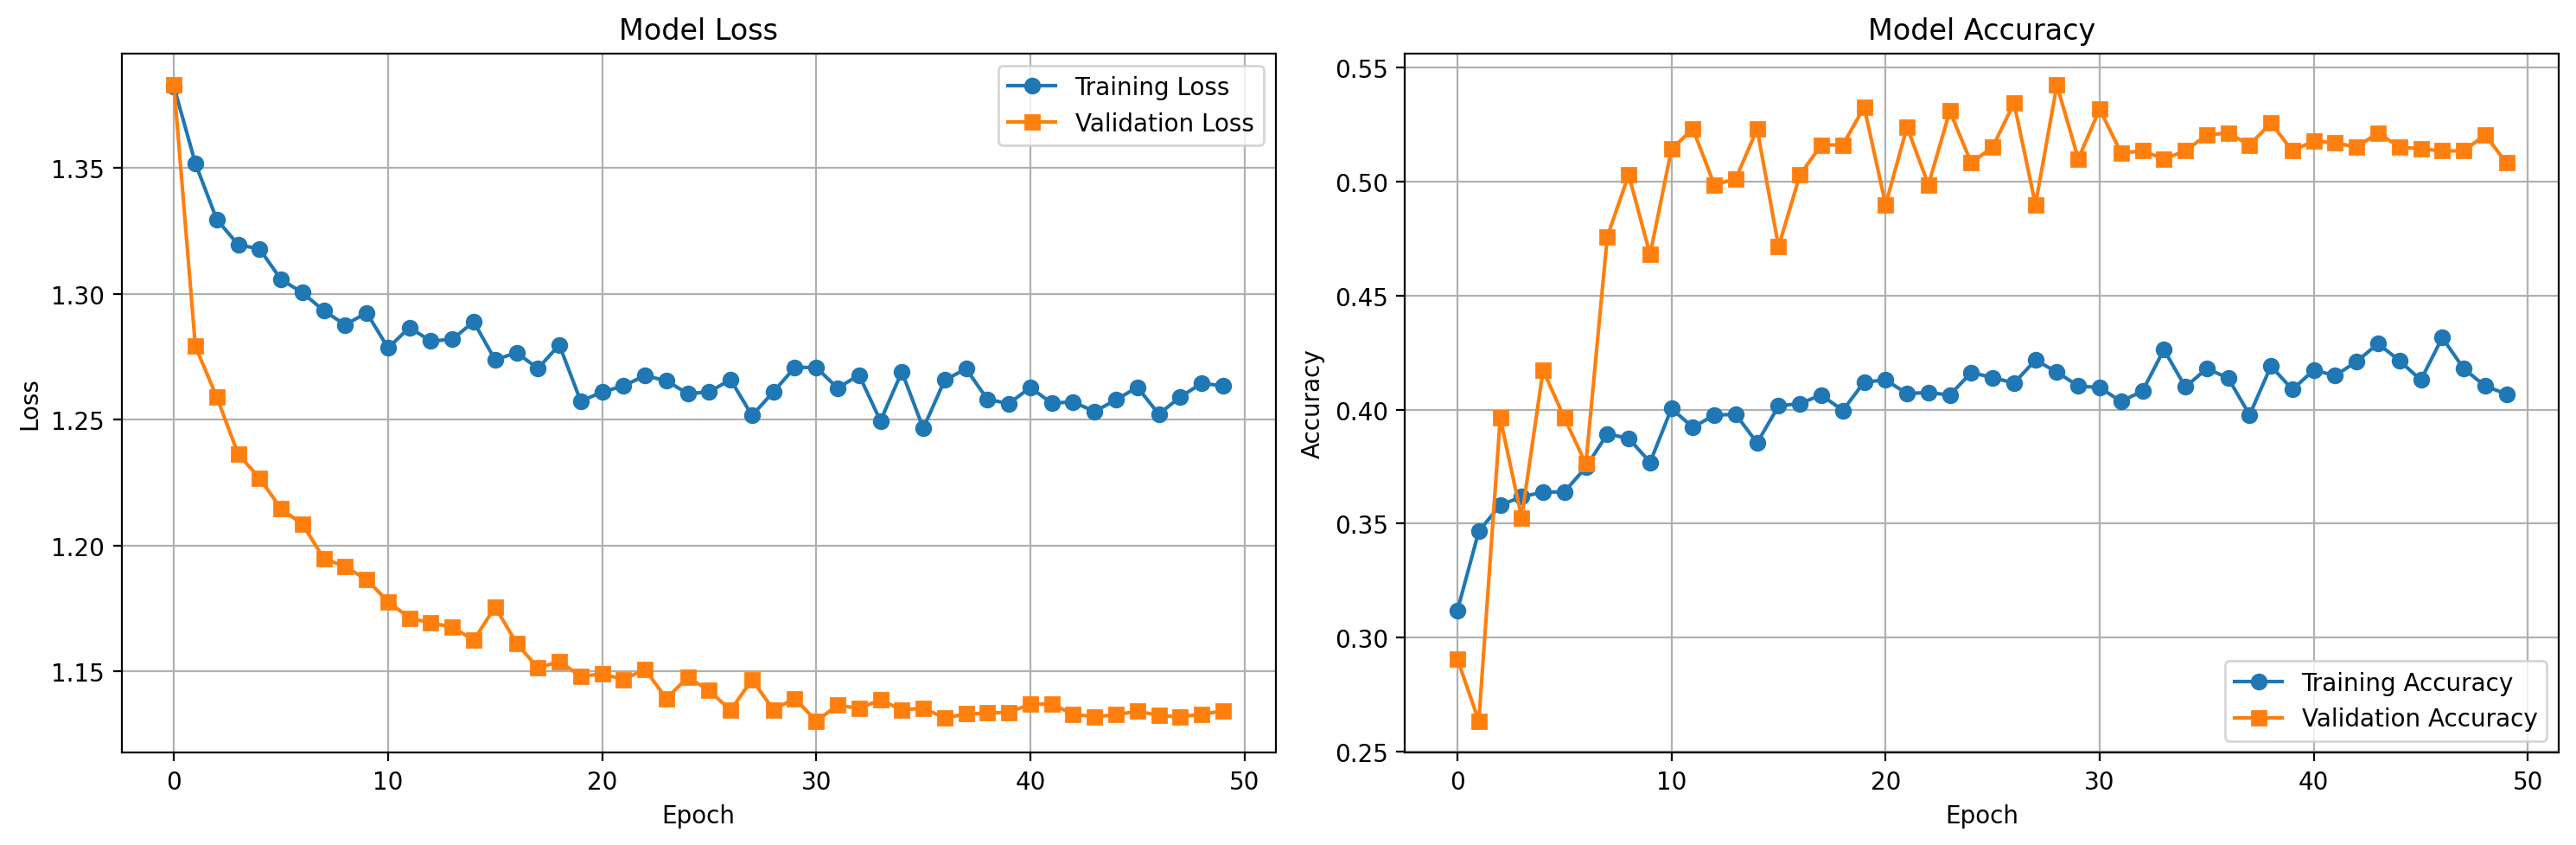

Best Training Accuracy: 0.4316
Best Validation Accuracy: 0.5424
Final Training Loss: 1.2635
Final Validation Loss: 1.1342


In [ ]:
import matplotlib.pyplot as plt

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
ax1.plot(history['loss'], label='Training Loss', marker='o')
ax1.plot(history['val_loss'], label='Validation Loss', marker='s')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot accuracy
ax2.plot(history['accuracy'], label='Training Accuracy', marker='o')
ax2.plot(history['val_accuracy'], label='Validation Accuracy', marker='s')
ax2.set_title('Model Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print final results
print(f"Best Training Accuracy: {max(history['accuracy']):.4f}")
print(f"Best Validation Accuracy: {max(history['val_accuracy']):.4f}")
print(f"Final Training Loss: {history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history['val_loss'][-1]:.4f}")

In [ ]:
torch.save(model.state_dict(), '/content/model.pt')

In [ ]:
import torch
import torch.nn.functional as F
from PIL import Image
import torchvision.transforms as transforms
import numpy as np

CLASS_NAMES = ['glioma', 'meningioma', 'notumor', 'pituitary']

def load_and_preprocess_image(image_path, target_size=(299, 299)):
    """
    Load and preprocess image for Xception model
    Xception typically uses 299x299 input size
    """
    # Load image
    image = Image.open(image_path).convert('RGB')

    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225]) 
    ])

    image_tensor = transform(image).unsqueeze(0)  # Shape: [1, 3, 299, 299]
    return image_tensor

def predict_brain_tumor(model, image_path, device='cuda'):
    """
    Predict brain tumor class for a single image
    """

    model.eval()
    model.to(device)

    image_tensor = load_and_preprocess_image(image_path)
    image_tensor = image_tensor.to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = F.softmax(outputs, dim=1)
        predicted_class_idx = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][predicted_class_idx].item()

    return predicted_class_idx, confidence, probabilities[0].cpu().numpy()


In [ ]:
model = BrainTumorClassifier(num_classes=4)
model.load_state_dict(torch.load('/content/model.pt', map_location='cuda'))

predicted_idx, confidence, probs = predict_brain_tumor(model, '/content/Te-pi_0015.jpg')
print(f"Prediction: {CLASS_NAMES[predicted_idx]} with {confidence*100:.1f}% confidence")

Prediction: glioma with 26.7% confidence
